In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder

In [2]:
from sklearn.datasets import fetch_openml
concrete = fetch_openml(data_id='4353',as_frame=True)
X = concrete.data.iloc[:,0:8]
y = concrete.data.iloc[:,8]

In [3]:
X.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270.0
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365.0
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360.0


In [4]:
y.head()

0    79.99
1    61.89
2    40.27
3    41.05
4    44.30
Name: Concrete compressive strength(MPa. megapascals), dtype: float64

In [5]:
X = X.to_numpy()
y = y.to_numpy()

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
#Divisão de treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

In [8]:
class scale_min_max():
 def __init__(self):
  self.max = None
  self.min = None 
    
 def fit(self, data):
  self.max = data.max()
  self.min = data.min()
    
 def transform(self, data):
  return (data - self.min)/ (self.max-self.min)

 def inversa(self, data):
  return data * (self.max - self.min) + self.min

In [9]:
scale_x = scale_min_max()
scale_y = scale_min_max()

scale_x.fit(x_train)
scale_y.fit(y_train)

x_train_scaled = scale_x.transform(x_train)
x_val_scaled = scale_x.transform(x_val)

y_train_scaled = scale_y.transform(y_train)
y_val_scaled = scale_y.transform(y_val)

In [10]:
def relu(u):
    return np.maximum(0, u)

def relu_dif(u):
    return (u >= 0) * 1.0 

def afim(z):
    return z

def afim_dif(z):
    return np.ones(shape=z.shape) 

def tanh(u):
    return (np.exp(2*u) - 1)/(np.exp(2*u) + 1)

def tanh_dif(u):
    return 1 - np.tanh(u)**2

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_dif(z):
    return sigmoid(z) * (1 - sigmoid(z))

def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0)[None,:]

def softmax_dif(z):
    return softmax(z) * (1 - softmax(z))

def cost_mse(true, pred):
    return np.mean((true - pred)**2)

def cost_logistic(true, pred):
    return np.mean(- true * np.log(pred) - (1 - true) * np.log(1 - pred))

def cost_softmax(true, pred):
    return - np.sum(true * np.log(pred)) / len(true)

In [11]:
def RMSE(true, pred):
 rmse = np.sqrt(np.mean((true - pred)**2))
 return rmse

def MSE(true, pred):
 mse = np.mean((true - pred)**2)
 return mse

def MRE(y_true ,y_pred):
 mre = np.mean(np.abs((y_true - y_pred)/y_true))
 return mre

def ACC(y_true, y_pred):
 acc = (y_true == y_pred).sum()/len(y_pred)
 return acc

## Questão 1 (MLP para regressão)

In [12]:
class MLP_1L():
    
    def __init__(self, Nh=20, momentum=0.9, t=300, rate=0.0001, 
                 size_batch= 32, phi_1 = 'tanh', phi_2 = 'afim', cost = 'mse', reg = 0.1):      
        self.t = t
        self.rate = rate
        self.B = size_batch
        self.lamb = reg
                
        self.W = None
        self.M = None
        self.D = None
        self.Nh = Nh
        self.momentum = momentum
        self.K = 1
        
        self.atv_1 = phi_1
        self.atv_2 = phi_2
        self.phi_1 = None
        self.phi_2 = None
        self.cost = cost
        self.f_cost = None
        
        self.costs = []
        self.costs_val = []
        
        if self.atv_1 == 'tanh':
            self.phi_1 = np.tanh               
            self.phi_1_dif = tanh_dif
            
        if self.atv_1 == 'relu':
            self.phi_1 = relu                
            self.phi_1_dif = relu_dif                         
                      
        if self.atv_2 == 'afim':
            self.phi_2 = afim          
            self.phi_2_dif = afim_dif
            self.f_cost = cost_mse
            
        if self.atv_2 == 'sigmoid':
            self.phi_2 = sigmoid                
            self.phi_2_dif = sigmoid_dif
            self.f_cost = cost_logistic
            
        if self.atv_2 == 'softmax': 
            self.phi_2 = softmax                
            self.phi_2_dif = softmax_dif
            self.f_cost = cost_softmax          
        
    def fit(self, X, y, X_val, y_val):
        if self.atv_2 == 'softmax':
            self.K = len(np.unique(y))
        n = X.shape[0]
        X = np.c_[np.ones(X.shape[0]), X]
        X_val = np.c_[np.ones(X_val.shape[0]), X_val]
        y = y.reshape(-1,1) 
        y_val = y_val.reshape(-1,1)
        self.D = X.shape[1]
    
        self.W = np.random.normal(loc= 0, scale=1,size=(self.Nh,self.D)) * np.sqrt(1/self.D)
        self.W[:,0] = 0
        self.M = np.random.normal(loc= 0, scale=1,size=(self.K, self.Nh+1)) * np.sqrt(1/self.Nh+1)
        self.M[:, 0] = 0
        W_past_increment = 0
        M_past_increment = 0 
                               
        for epoch in range(self.t):
            random_index = np.random.permutation(len(y))
            X = X[random_index]
            index = np.arange(0, n, self.B)
            index[-1] = n
            for i in range(len(index)-1):
                start = index[i]
                end = index[i+1]
                X_batch = X[start:end, : ]
                y_batch = y[start:end]
                Z = np.zeros([len(X_batch), self.Nh+1])
                
                Z[:, 0] = 1                            
                u = X_batch @ self.W.T
                Z[:, 1:] = self.phi_1(u)
                r = Z @ self.M.T
                pred = self.phi_2(r)
                
                error = y_batch - pred
                delta = error * self.phi_2_dif(r)              
                zeta =  self.phi_1_dif(u) * (delta @ self.M[:, 1:])
                term_M = self.lamb*self.M
                term_M[:, 0] = 0
                self.M = self.M + self.rate * (delta.T @ Z - term_M) +  self.momentum * M_past_increment
                M_past_increment = self.rate * (delta.T @ Z - term_M)
                term_W = self.lamb*self.W
                term_W[:,0] = 0
                self.W = self.W + self.rate * (zeta.T @ X_batch - term_W) + self.momentum * W_past_increment
                W_past_increment = self.rate * (zeta.T @ X_batch - term_W)
                
                Z = np.zeros([len(X), self.Nh+1])
                Z[:, 0] = 1                
                u = X @ self.W.T
                Z[:, 1:] = self.phi_1(u)
                r = Z @ self.M.T
                y_pred  = self.phi_2(r)                                 
                loss = self.f_cost(y, y_pred)/2
                self.costs.append(loss)
                
                Z = np.zeros([len(X_val), self.Nh+1])
                Z[:, 0] = 1                
                u = X_val @ self.W.T
                Z[:, 1:] = self.phi_1(u)
                r = Z @ self.M.T
                y_pred_val  = self.phi_2(r)        
                loss_val = self.f_cost(y_val, y_pred_val)/2
                self.costs_val.append(loss_val)
                
    def predict(self, X):
        
        X = np.c_[np.ones(X.shape[0]), X]        
        Z = np.zeros([len(X), self.Nh+1])
        Z[:, 0] = 1                
        u = X @ self.W.T
        Z[:, 1:] = self.phi_1(u)
        r = Z @ self.M.T
        y_pred  = self.phi_2(r)
        return y_pred

In [13]:
grid = {
    'Nh':[15 , 35 ,50,100],
    'rate':[0.0001 ,0.00001],
    'reg' : [0 ,0.01, 0.1, 0.25, 0.4]
    }

def RandomSearch(modelo, grid, qtd, cost):
    combinations = []
    while len(combinations) < qtd:
        a = {}
        for yi in grid.keys():
            a[yi] = np.random.choice(grid[yi])
            if a not in combinations:
                combinations.append(a)
                
    scores = []      
    for comb in combinations:
        model = modelo(**comb)
        model.fit(x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled)
        y_pred = model.predict(x_val_scaled)
        y_pred = scale_y.inversa(y_pred)
        scores.append(cost(y_val, y_pred))
        print(comb)
        print(cost(y_val, y_pred))
        print("----")
        
    scores = np.array(scores)
    best_index = np.argmin(scores)
    best = combinations[best_index]
        
    return best, combinations, scores
        

### RamdomSearch usando o conjunto de validação


In [14]:
best, combinations, scores = RandomSearch(MLP_1L, grid, 20, RMSE)

{'Nh': 35, 'rate': 1e-05, 'reg': 0.1}
17.504496983396084
----
{'Nh': 35, 'rate': 1e-05, 'reg': 0.01}
17.449493964538206
----
{'Nh': 15, 'rate': 1e-05, 'reg': 0.0}
20.705879986810004
----
{'Nh': 50, 'rate': 0.0001, 'reg': 0.1}
16.901025273245647
----
{'Nh': 35, 'rate': 0.0001, 'reg': 0.1}
17.024899899163703
----
{'Nh': 35, 'rate': 0.0001, 'reg': 0.4}
16.904513950537257
----
{'Nh': 50, 'rate': 0.0001, 'reg': 0.01}
16.957409477405587
----
{'Nh': 100, 'rate': 0.0001, 'reg': 0.25}
16.88283231327997
----
{'Nh': 50, 'rate': 0.0001, 'reg': 0.25}
16.91344941648791
----
{'Nh': 15, 'rate': 1e-05, 'reg': 0.4}
18.619448002561032
----
{'Nh': 100, 'rate': 0.0001, 'reg': 0.4}
16.87802096755491
----
{'Nh': 50, 'rate': 0.0001, 'reg': 0.1}
16.977729568113176
----
{'Nh': 35, 'rate': 1e-05, 'reg': 0.01}
19.657330385032484
----
{'Nh': 15, 'rate': 0.0001, 'reg': 0.25}
16.86973009910636
----
{'Nh': 15, 'rate': 0.0001, 'reg': 0.25}
16.952829293948962
----
{'Nh': 15, 'rate': 0.0001, 'reg': 0.4}
16.8490865932743

In [15]:
best

{'Nh': 15, 'rate': 0.0001, 'reg': 0.4}

In [16]:
np.argmin(scores)

15

### Performance para o conjunto de validação

In [17]:
model = MLP_1L(**best)

model.fit(x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled)
y_pred = model.predict(x_val_scaled)
y_pred = scale_y.inversa(y_pred)


mre = MRE(y_val, y_pred)
RMSE = np.sqrt(MSE(y_val, y_pred))

print("MRE: {}".format(mre))
print("RMSE: {}".format(RMSE))

MRE: 0.6085982970956474
RMSE: 16.82599733466566


**Curva de aprendizagem para treino e validação**

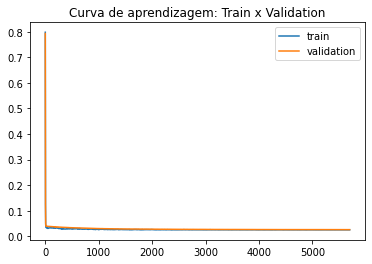

In [18]:
plt.plot(model.costs, label='train')
plt.plot(model.costs_val, label='validation')
plt.title("Curva de aprendizagem: Train x Validation")
plt.legend()

### Performance para o conjunto de treino

In [19]:
y_pred = model.predict(x_train_scaled)
y_pred = scale_y.inversa(y_pred)


mre = MRE(y_train, y_pred)
RMSE = np.sqrt(MSE(y_train, y_pred))

print("MRE: {}".format(mre))
print("RMSE: {}".format(RMSE))


MRE: 0.6063459973159556
RMSE: 16.836396033461323


### Treinando o modelo usando treino e validação e avaliando no conjunto de teste

In [20]:
scale_x.fit(x_train)
scale_y.fit(y_train)

x_train_scaled  = scale_x.transform(x_train)
x_val_scaled = scale_x.transform(x_test)

y_train_scaled = scale_y.transform(y_train)
y_val_scaled = scale_y.transform(y_train)

In [21]:
model = MLP_1L(**best)

model.fit(x_train, y_train, x_val, y_val)
y_pred = model.predict(x_val)
y_pred = scale_y.inversa(y_pred)


mre = MRE(y_test, y_pred)
RMSE = np.sqrt(MSE(y_test, y_pred))

print("MRE: {}".format(mre))
print("RMSE: {}".format(RMSE))

MRE: 90.30078896061805
RMSE: 2586.0937339909215


## Questão 2 (MLP para classificação)

In [22]:
dados_vowel = np.genfromtxt('./Dados/vowel.csv', delimiter = ',', skip_header = 0)

In [23]:
dados_vowel = np.genfromtxt('./Dados/vowel.csv', delimiter = ',', skip_header = 0)
np.set_printoptions()

In [24]:
X = dados_vowel[:, 0:-1]
y = dados_vowel[:, [-1]]

In [25]:
n_classes = len(np.unique(y)) # número de classes
Y = np.zeros((y.shape[0], n_classes)) # inicializando a matriz Y com zeros

In [26]:
n = X.shape[0] # tamanho da amostra original
D = X.shape[1] # número de dimensões de entrada (atributos)
K = Y.shape[1] # número de dimensões de saída (classes)
n_train = round(0.6*n) # tamanho da amostra de treino
n_validacao = round(0.2*n) # tamanho da amostra de validação
n_teste = n - n_train - n_validacao # tamanho da amostra de teste

In [27]:
def norm_min_max(X, X_train): # normalização min-max dos dados
  X_train_min = X_train.min(axis=0) # valor mínimo de cada atributo/coluna
  X_train_max = X_train.max(axis=0) # valor máximo de cada atributo/coluna
  X = (X - X_train_min) / (X_train_max - X_train_min) # normalizando os valores das variáveis x na mesma escala dos dados de treino
  return X

In [38]:
def MLP_1co_direto(X, Y, W, M, f_ativ_oculta, f_ativ_saida, f_custo): # sentido direto da rede MLP com 1 camada oculta
  U = X @ W
  Zi = np.array(list(map(globals()[f_ativ_oculta], U))) # matriz de saída da camada oculta com a função de ativação
  Z = np.c_[np.ones(Zi.shape[0]), Zi] # inserindo o termo de viés
  R = Z @ M
  Y_pred = np.array(list(map(globals()[f_ativ_saida], R))) # vetor de saída com a função de ativação
  erro = Y - Y_pred
  if f_custo == 'MSE':
    custo = (1/(2*Y.shape[0])) * (erro**2).sum() # computando o erro quadrático médio
  if f_custo == 'entropia':
    custo = (-1/Y.shape[0]) * (Y * np.log(Y_pred)).sum() # computando a entropia cruzada
  return Z, Y_pred, erro, custo

def MLP_train(X_train, Y_train, X_validacao, Y_validacao, f_ativ_oculta, f_ativ_saida, f_custo, alfa_0, n_epocas, momentum, n_neuronios, B, termo_reg, validacao = True): # treinamento da rede MLP
  # Inicialização dos parâmetros
  D = X_train.shape[1] # número de dimensões de entrada (atributos)
  if f_ativ_oculta == 'relu':
    W = np.sqrt(2/(D+1)) * np.random.normal(size = (D, n_neuronios)) # inicialização da matriz de parâmetros da camada de entrada => camada oculta
    W = np.r_[0.01*np.ones((1, n_neuronios)), W] # inicialização do viés de cada neurônio = 0.01
  else:
    W = np.sqrt(1/(D+1)) * np.random.normal(size = (D, n_neuronios)) # inicialização da matriz de parâmetros da camada de entrada => camada oculta
    W = np.r_[np.zeros((1, n_neuronios)), W] # inicialização do viés de cada neurônio = 0
  W_ant = W # matriz W da iteração anterior, para termo de momentum
  
  K = Y_train.shape[1] # número de dimensões de saída
  if f_ativ_saida == 'relu':
    M = np.sqrt(2/(n_neuronios + 1)) * np.random.normal(size = (n_neuronios, K)) # inicialização da matriz de parâmetros da camada oculta => camada de saída
    M = np.r_[0.01*np.ones((1, K)), M] # inicialização do viés de cada neurônio = 0.01
  else:
    M = np.sqrt(1/(n_neuronios + 1)) * np.random.normal(size = (n_neuronios, K)) # inicialização da matriz de parâmetros da camada oculta => camada de saída
    M = np.r_[np.zeros((1, K)), M] # inicialização do viés de cada neurônio = 0
  M_ant = M # matriz M da iteração anterior, para termo de momentum

  # Etapa de treinamento e validação
  custo_train_it = [] # histórico dos valores da função custo de treino em cada iteração (mini-batch), geralmente utilizado com muitos dados devido ao custo de execução do algoritmo
  custo_validacao_ep = [] # histórico dos valores da função custo de validação em cada época
  custo_validacao_min = np.inf # inicializando o custo mínimo de validação como infinito (para escolher melhor modelo durante o treinamento/validação)
  n_iteracoes = int(np.ceil(X_train.shape[0] / B)) # número de iterações (mini-batches) por época
  for epoca in range(n_epocas):
    I_train = np.random.permutation(X_train.shape[0]) # permutação dos índices das observações de treinamento
    X_train_ep = X_train[I_train] # embaralhamento dos padrões de treinamento
    Y_train_ep = Y_train[I_train] # embaralhamento dos dados de saída de treinamento
    alfa = alfa_0 / (1 + epoca) # decaimento exponencial da taxa de aprendizagem
    
    for t in range(n_iteracoes):
      X_t = X_train_ep[(t*B):((t+1)*B),] # selecionando apenas os padrões do mini-batch
      X_t = np.c_[np.ones(X_t.shape[0]), X_t] # inserindo o termo de viés
      Y_t = Y_train_ep[(t*B):((t+1)*B),] # selecionando apenas as saídas dos padrões do mini-batch
      
      MLP_dir_train = MLP_1co_direto(X_t, Y_t, W, M, f_ativ_oculta, f_ativ_saida, f_custo) # sentido direto da rede MLP aplicado aos dados de treinamento da iteração
      erro = MLP_dir_train[2]
      custo_train_it.append(MLP_dir_train[3]) # custo de treino da iteração (mini-batch)

      Z_t = MLP_dir_train[0]
      R = Z_t @ M
      dY = -erro # gradiente local da camada de saída (para os casos específicos tratados aqui)
      M_aux = M # matriz de parâmetros auxiliar (para manter a matriz de parâmetros da iteração anterior)
      M_reg = M # matriz dos parâmetros a serem regularizados
      M_reg[0,:] = np.zeros((1, K)) # removendo o termo de viés da regularização
      M += -(alfa/B) * (Z_t.T @ dY + termo_reg * M_reg) + momentum * (M - M_ant) # atualização dos parâmetros da camada oculta => camada de saída
      M_ant = M_aux # atualizando a matriz de parâmetros da iteração anterior

      U = X_t @ W
      dU = np.array(list(map(globals()['deriv_' + f_ativ_oculta], U))) # derivada da função de ativação da camada oculta
      dZ = dU * (dY @ M[1:,].T) # gradiente local da camada oculta
      W_aux = W # matriz de parâmetros auxiliar (para manter a matriz de parâmetros da iteração anterior)
      W_reg = W # matriz dos parâmetros a serem regularizados (não se remove o termo de viés da camada oculta da regularização porque não se tem uma saída desejada)
      W += -(alfa/B) * (X_t.T @ dZ + termo_reg * W_reg) + momentum * (W - W_ant) # atualização dos parâmetros da camada de entrada => camada oculta
      W_ant = W_aux # atualizando a matriz de parâmetros da iteração anterior

    if validacao == True:
      MLP_validacao = MLP_1co_direto(X_validacao, Y_validacao, W, M, f_ativ_oculta, f_ativ_saida, f_custo) # sentido direto da rede MLP aplicado aos dados de validação
      custo_validacao = MLP_validacao[3] # custo médio de validação da época
      custo_validacao_ep.append(custo_validacao)

      if custo_validacao < custo_validacao_min:
        custo_validacao_min = custo_validacao
        W_melhor = W # atualizando matriz de parâmetros associados ao melhor modelo durante o treinamento/validação
        M_melhor = M # atualizando matriz de parâmetros associados ao melhor modelo durante o treinamento/validação
    
    else:
      W_melhor = W
      M_melhor = M
  return W_melhor, M_melhor, custo_train_it, custo_validacao_ep

In [37]:
# Divisão das amostras e normalização dos dados
I = np.random.permutation(n) # permutação dos índices das observações
(X_train, X_validacao, X_teste) = (X[I][:n_train,], X[I][n_train:(n_train + n_validacao),], X[I][(n - n_teste):,])
(Y_train, Y_validacao, Y_teste) = (Y[I][:n_train,], Y[I][n_train:(n_train + n_validacao),], Y[I][(n - n_teste):,])

X_train = norm_min_max(X_train, X_train)
X_validacao = norm_min_max(X_validacao, X_train)
X_teste = norm_min_max(X_teste, X_train)

X_validacao = np.c_[np.ones(n_validacao), X_validacao] # inserindo o termo de viés
X_teste = np.c_[np.ones(n_teste), X_teste] # inserindo o termo de viés

# Busca pelos hiperparâmetros ótimos
n_iteracoes_hp = 1000 # número de iterações na busca pelos hiperparâmetros ótimos
f_ativ_oculta = 'relu'
f_ativ_saida = 'softmax'
f_custo = 'entropia'

custo_hp_min = np.inf # inicializando o custo mínimo de validação como infinito (para escolher melhor combinação de hiperparâmetros)
for i in range(n_iteracoes_hp):
  # Hiperparâmetros
  alfa_0 = 10**np.random.uniform(-5, -1) # taxa de aprendizagem inicial
  n_epocas = np.random.randint(200, 500) # número de épocas
  momentum = np.random.uniform(0.5, 1) # termo de momentum
  n_neuronios = np.random.randint(11, 200) # número de neurônios
  B = np.random.randint(10, 100) # quantidade de padrões utilizados por mini-batch durante o treinamento
  termo_reg = np.random.uniform(0.01, 0.1) # termo de regularização

  # Etapa de treinamento e validação
  rede_MLP = MLP_train(X_train, Y_train, X_validacao, Y_validacao, f_ativ_oculta, f_ativ_saida, f_custo, alfa_0, n_epocas, momentum, n_neuronios, B, termo_reg, validacao = True)
  (W_hp, M_hp) = (rede_MLP[0], rede_MLP[1]) 

  MLP_validacao = MLP_1co_direto(X_validacao, Y_validacao, W_hp, M_hp, f_ativ_oculta, f_ativ_saida, f_custo) # sentido direto da rede MLP aplicado aos dados de validação
  custo_validacao = MLP_validacao[3] # custo de validação do melhor modelo

  if custo_validacao < custo_hp_min:
    custo_hp_min = custo_validacao
    (W_melhor, M_melhor) = (W_hp, M_hp) # atualizando matrizes de parâmetros associados ao melhor modelo durante o treinamento/validação
    (alfa_0_melhor, n_epocas_melhor, momentum_melhor, n_neuronios_melhor, B_melhor, termo_reg_melhor) = (alfa_0, n_epocas, momentum, n_neuronios, B, termo_reg) # atualizando melhor combinação de hiperparâmetros
    (custo_train_it_melhor, custo_validacao_ep_melhor) = (rede_MLP[2], rede_MLP[3])

plt.plot(custo_train_it_melhor) # curva de aprendizagem de train para a melhor combinação de hiperparâmetros
plt.xlabel("Iteração")
plt.ylabel("Entropia cruzada")
plt.title("Treinamento via SGD com momentum");

print("Hiperparâmetros do melhor modelo:")
print("taxa de aprendizagem inicial: %.3f, número de épocas: %d, termo de momentum: %.2f, número de neurônios: %d, tamanho do mini-batch: %d e termo de regularização: %.2f" % 
      (alfa_0_melhor, n_epocas_melhor, momentum_melhor, n_neuronios_melhor, B_melhor, termo_reg_melhor), end = '\n\n')

# Etapa de teste (Generalização)
MLP_teste = MLP_1co_direto(X_teste, Y_teste, W_melhor, M_melhor, f_ativ_oculta, f_ativ_saida, f_custo) # sentido direto da rede MLP aplicado aos dados de teste
custo_teste = MLP_teste[3] # entropia cruzada de teste
print("Entropia cruzada de teste: %.4f" % custo_teste)

IndexError: invalid index to scalar variable.

In [30]:
plt.plot(custo_validacao_ep_melhor) # curva de aprendizagem de validação para a melhor combinação de hiperparâmetros
plt.xlabel("Época")
plt.ylabel("Entropia cruzada")
plt.title("Validação");

NameError: name 'custo_validacao_ep_melhor' is not defined

In [31]:
# Hiperparâmetros
f_ativ_oculta = 'relu' # já que se trata de um problema de classificação
f_ativ_saida = 'softmax' # já que se trata de um problema multiclasse
f_custo = 'entropia' # já que se trata de um problema de classificação
alfa_0 = alfa_0_melhor # taxa de aprendizagem inicial
n_epocas = n_epocas_melhor # número de épocas
momentum = momentum_melhor # termo de momentum
n_neuronios = n_neuronios_melhor # número de neurônios
B = B_melhor # quantidade de padrões utilizados por mini-batch durante o treinamento
termo_reg = termo_reg_melhor # termo de regularização

# Etapa de treinamento
X_retrain = np.r_[X_train, X_validacao[:, 1:]] # juntando dados de treino e validação
Y_retrain = np.r_[Y_train, Y_validacao] # juntando dados de treino e validação

rede_MLP = MLP_train(X_retrain, Y_retrain, None, None, f_ativ_oculta, f_ativ_saida, f_custo, alfa_0, n_epocas, momentum, n_neuronios, B, termo_reg, validacao = False)
(W, M) = (rede_MLP[0], rede_MLP[1]) # matrizes de parâmetros da rede MLP retreinada

plt.plot(rede_MLP[2]) # curva de aprendizagem de treino
plt.xlabel("Iteração")
plt.ylabel("Entropia cruzada")
plt.title("Treinamento via SGD com momentum");

# Etapa de teste (Generalização)
MLP_teste = MLP_1co_direto(X_teste, Y_teste, W, M, f_ativ_oculta, f_ativ_saida, f_custo) # sentido direto da rede MLP aplicado aos dados de teste
custo_teste = MLP_teste[3] # custo de teste
print("Entropia cruzada de teste (normalizado): %.4f" % custo_teste)

NameError: name 'alfa_0_melhor' is not defined

In [32]:
def acertos(Y, Y_pred): # retorna o número e a taxa de acertos (acurácia) gerais de classificação
  n = Y.shape[0] # quantidade de padrões
  n_acertos = 0
  for i in range(n):
    classe_pred = np.argmax(Y_pred[i,:])
    if Y[i, classe_pred] == 1:
      n_acertos += 1
  p_acertos = n_acertos/n
  return n_acertos, p_acertos

In [33]:
X_train_2 = np.c_[np.ones(n_train), X_train] # inserindo o termo de viés
direto_train = MLP_1co_direto(X_train_2, Y_train, W, M, f_ativ_oculta, f_ativ_saida, f_custo) # sentido direto da rede MLP aplicado aos dados de treino
Y_pred_train = direto_train[1] # valores preditos de treino
acertos_train = acertos(Y_train, Y_pred_train) # acertos de treino
acertos_classe_train = acertos_classe(Y_train, Y_pred_train) # acertos de treino por classe

direto_validacao = MLP_1co_direto(X_validacao, Y_validacao, W, M, f_ativ_oculta, f_ativ_saida, f_custo) # sentido direto da rede MLP aplicado aos dados de validação
Y_pred_validacao = direto_validacao[1] # valores preditos de validação
acertos_validacao = acertos(Y_validacao, Y_pred_validacao) # acertos de validação
acertos_classe_validacao = acertos_classe(Y_validacao, Y_pred_validacao) # acertos de validação por classe

direto_teste = MLP_1co_direto(X_teste, Y_teste, W, M, f_ativ_oculta, f_ativ_saida, f_custo) # sentido direto da rede MLP aplicado aos dados de teste
Y_pred_teste = direto_teste[1] # valores preditos de teste
acertos_teste = acertos(Y_teste, Y_pred_teste) # acertos de teste
acertos_classe_teste = acertos_classe(Y_teste, Y_pred_teste) # acertos de teste por classe

print("Acurácia de treino, validação e teste: %.2f%%, %.2f%% e %.2f%%" % (100*acertos_treino[1], 100*acertos_validacao[1], 100*acertos_teste[1]))

NameError: name 'W' is not defined